# CBP transmission with laser filter wheel - run 2021-07-30

The goal of this notebook is to check the CBP transmission around the "step" at 532nm with different filters.

In [20]:
import os, sys
print(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

from astropy import constants as const
from astropy import units as u
from scipy.interpolate import interp1d

from solarcell_dataset import SolarCellDataSet, SolarCellRun, calculate_npulses, get_info_from_filename, estimate_noise, get_solarcell_total_charge
%matplotlib notebook

/home/jneveu/stardice/analysis/cbp_paper


Run at normal indicence :

In [46]:
datapath="/data/STARDICE/cbp/solarcell/ut20210730/Filterwheel_2"
other_str=""
nbursts = 5

run = SolarCellRun(directory_path=datapath, nbursts=nbursts, tag=other_str)
run.load()
run.load_from_file(os.path.join(datapath, f"QSWMax_LaserFilterWheel_5mm_ntuple.npy"))

100%|██████████| 140/140 [00:05<00:00, 26.54it/s]


In [47]:
run.data

array([('1064', 'Max', 5,  721, 515., -8.64713645e-08, 2.68102848e-11,  3.29856786e-07, 1.22769950e-09, -2.69849780e-12,  3.23325890e-12, -2.46075002e-08, -2.44058032e-08),
       ('EMPTY', 'Max', 5,  721, 515., -1.32606357e-07, 3.19539274e-11,  5.01280497e-07, 8.74775801e-10, -6.71205955e-13,  6.21902586e-12, -2.38177615e-08, -2.53737963e-08),
       ('blue680', 'Max', 5,  721, 515., -1.31375495e-07, 6.12928799e-11,  5.01513488e-07, 1.12127819e-09, -9.82616919e-12,  3.83014477e-12, -2.42530121e-08, -2.23994781e-08),
       ('red532', 'Max', 5,  721, 515.,  2.58493941e-26, 1.34314958e-11,  3.22441962e-09, 1.07277732e-09, -2.02069065e-11, -2.02069065e-11, -3.03089643e-08, -2.93242083e-08),
       ('1064', 'Max', 5,  722, 516., -9.08623559e-08, 3.75237488e-11,  3.46147566e-07, 1.33475488e-09, -5.20346223e-12,  3.08006022e-12, -2.34708835e-08, -2.30900980e-08),
       ('EMPTY', 'Max', 5,  722, 516., -1.32756369e-07, 2.26479153e-11,  5.05474858e-07, 1.24618837e-09, -9.29354759e-13,  4.0381

<IPython.core.display.Javascript object>


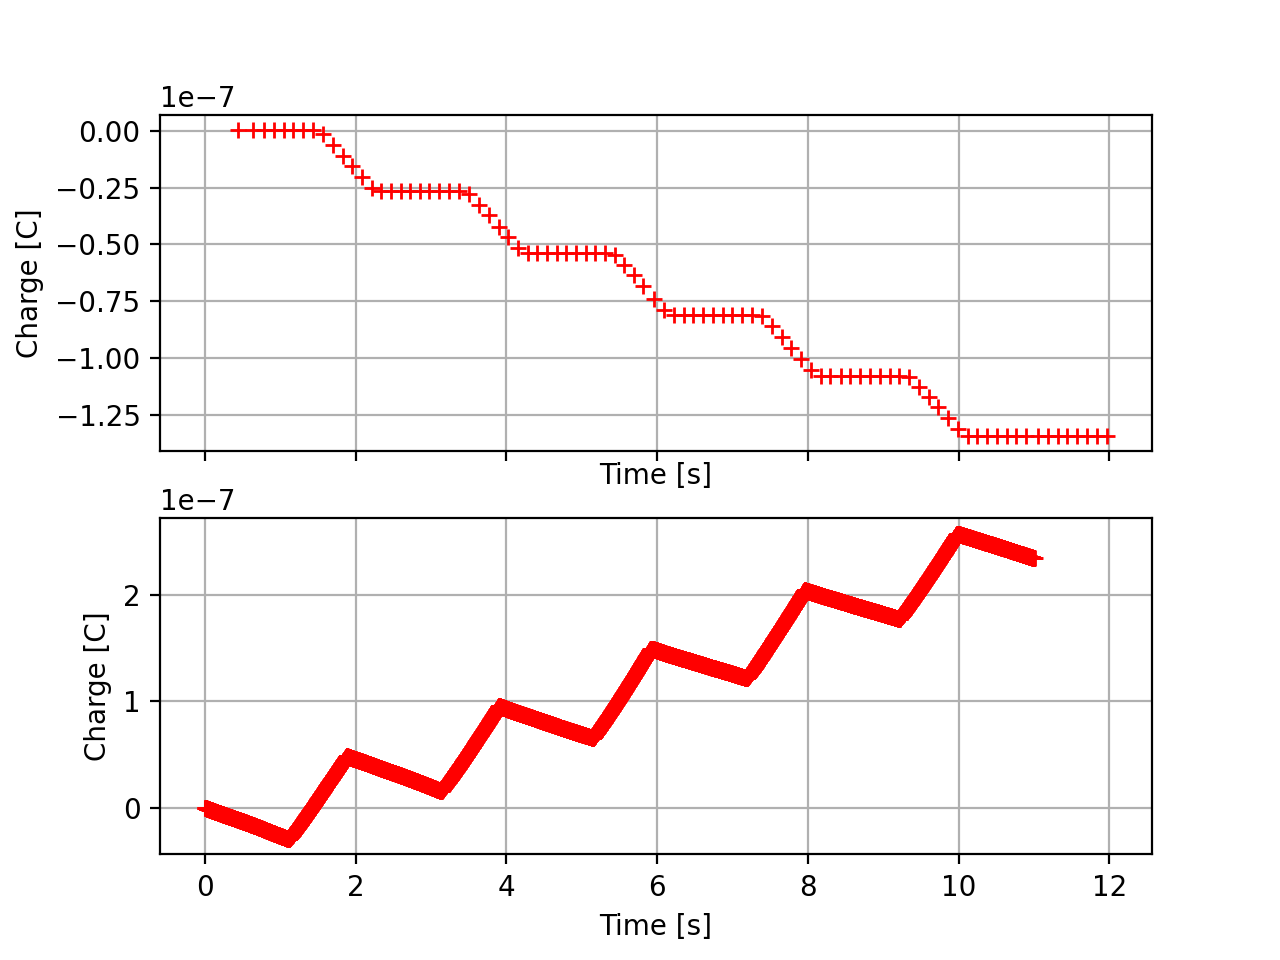

In [48]:
d = run.get_data_set(520, 5, {"laserfilter": "EMPTY"})
d.plot_data_set()

<IPython.core.display.Javascript object>


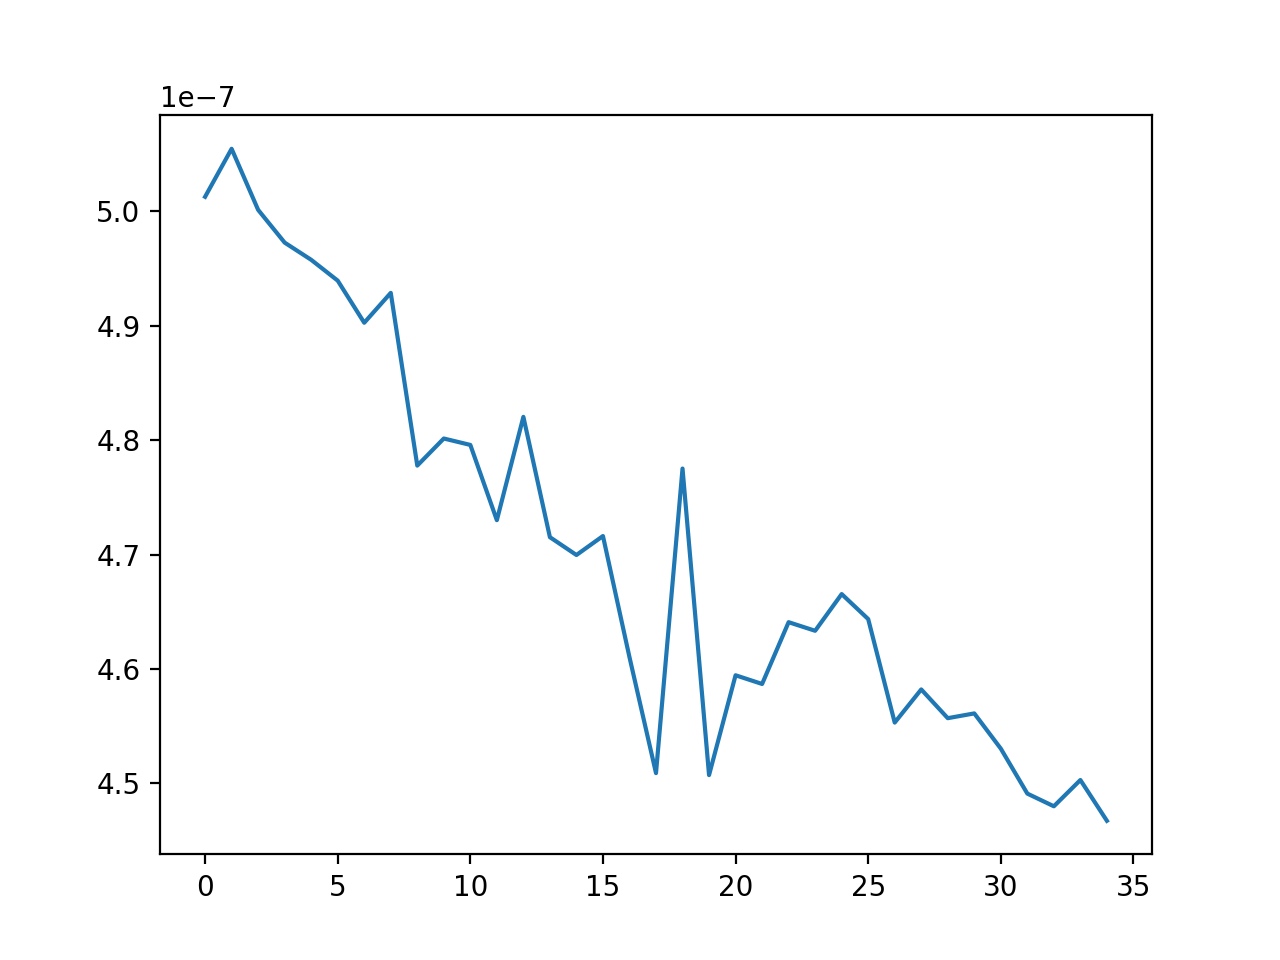

In [49]:
fig=plt.figure()
plt.plot(run.data["sc_charge_total"][run.data["laserfilter"]=="EMPTY"])

### CBP transmissions with filters

In [50]:
ref_data_root = "/data/STARDICE/cbp/solarcell/refCalData/"
SC_QE_data_file = ref_data_root + 'SC_QE_from_mono_SC_ED_20210618_MultiDay.txt'
PD_QE_data_file = ref_data_root + 'SM05PD1B_QE.csv'

SC_QE = np.loadtxt(SC_QE_data_file, skiprows=1, delimiter=",").T
PD_QE = np.loadtxt(PD_QE_data_file, skiprows=1, delimiter=",").T

# PD_QE is in A/W units, convert it to e-/photons as SC_QE
PD_QE[1] *= (const.h * const.c / (PD_QE[0] * 1e-9 * u.meter * const.e.value)).value

SC_QE_f = interp1d(SC_QE[0], SC_QE[1], bounds_error=False, fill_value=np.min(SC_QE[1]))
PD_QE_f = interp1d(PD_QE[0], PD_QE[1], bounds_error=False, fill_value=np.min(PD_QE[1]))


<IPython.core.display.Javascript object>


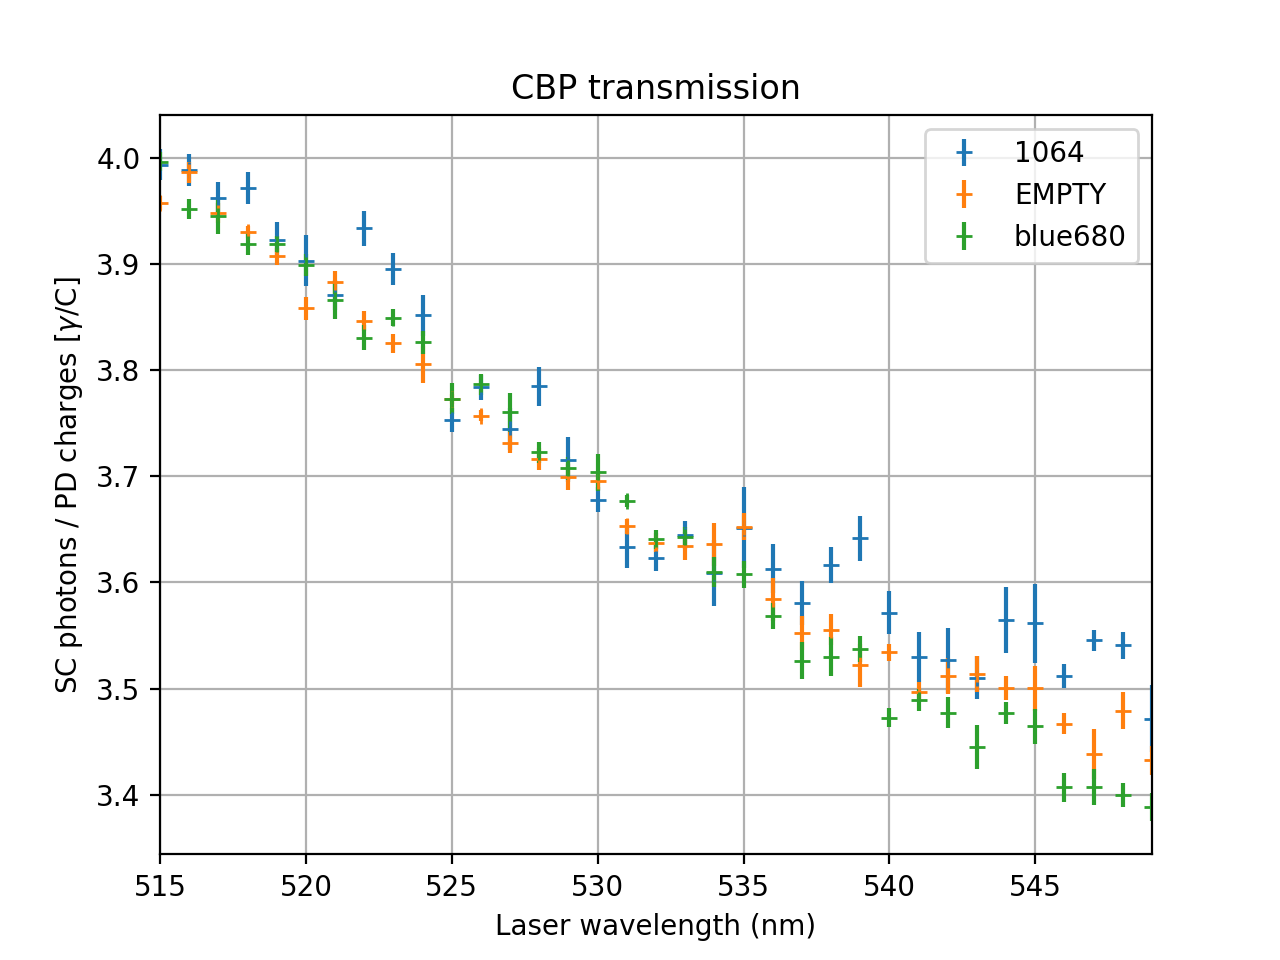

In [52]:
double_Al_wavelength, double_Al_responsivity = np.loadtxt(os.path.join(ref_data_root, 'TwoBounceAl.dat'), delimiter=',', skiprows=1).T
Al_wl, Al_CFHT = np.loadtxt(os.path.join(ref_data_root, 'CFHT_Primary_Transmission.dat'), delimiter=' ', skiprows=0).T
Al_wl *= 0.1
Al_CFHT *= Al_CFHT

fig = plt.figure()

for flt in np.unique(run.data["laserfilter"]):
    if "red532" in flt : continue
    ind = run.data["laserfilter"] == flt
    tr = (run.data["sc_charge_total"][ind] / SC_QE_f(run.data["set_wl"][ind])) /  (-run.data["pd_charge_total"][ind])
    tr_err = tr * np.sqrt((run.data["sc_charge_total_err"][ind]/run.data["sc_charge_total"][ind])**2 + (run.data["pd_charge_total_err"][ind]/run.data["pd_charge_total"][ind])**2)
    plt.errorbar(run.data["set_wl"][ind], tr, yerr=tr_err, marker='+', linestyle="none", label=flt)
#plt.plot(double_Al_wavelength, 2*double_Al_responsivity / PD_QE_f(double_Al_wavelength), '-', label="theory")
#plt.plot(Al_wl, 2*Al_CFHT / PD_QE_f(Al_wl), '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD charges [$\gamma$/C]')
plt.grid()
plt.xlim(np.min(run.data["set_wl"]), np.max(run.data["set_wl"]))
plt.title("CBP transmission")
plt.legend()
#plt.ylim(0, 10)
plt.show()



<IPython.core.display.Javascript object>


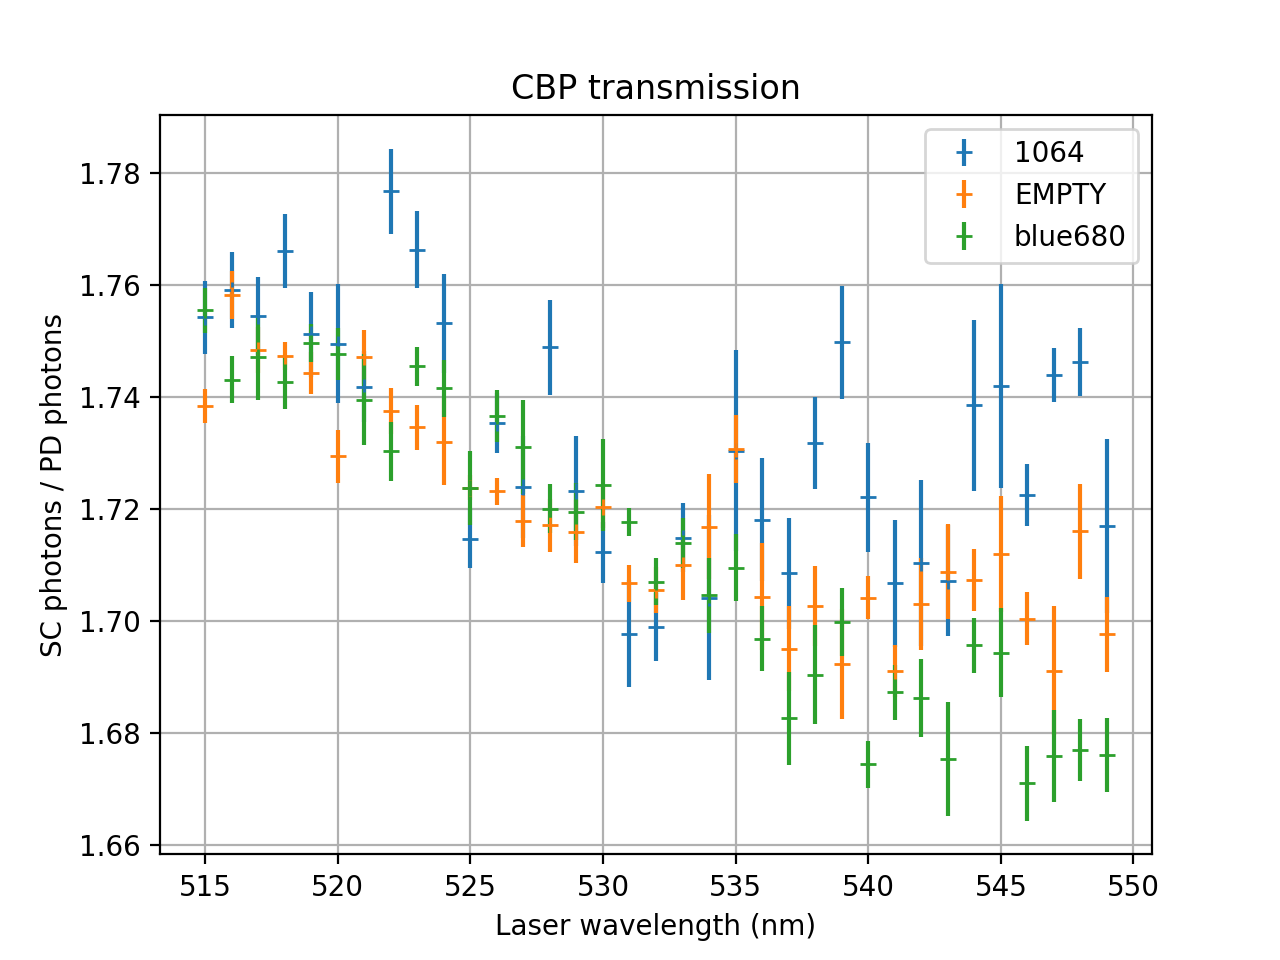

In [54]:
fig = plt.figure()

for flt in np.unique(run.data["laserfilter"]):
    if "red532" in flt : continue
    ind = run.data["laserfilter"] == flt
    tr = (run.data["sc_charge_total"][ind] / SC_QE_f(run.data["set_wl"][ind])) /  (-run.data["pd_charge_total"][ind] / PD_QE_f(run.data["set_wl"][ind]))
    tr_err = tr * np.sqrt((run.data["sc_charge_total_err"][ind]/run.data["sc_charge_total"][ind])**2 + (run.data["pd_charge_total_err"][ind]/run.data["pd_charge_total"][ind])**2)
    plt.errorbar(run.data["set_wl"][ind], tr, yerr=tr_err, marker='+', linestyle="none", label=flt)
#plt.plot(double_Al_wavelength, 6*double_Al_responsivity, '-', label="theory")
#plt.plot(Al_wl, 6*Al_CFHT, '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD photons')
plt.title("CBP transmission")
plt.grid()
plt.legend()
plt.show()
